In [1]:
import sys
import numpy as np
import argparse
from importlib import reload 



import cleese_stim as cleese
from cleese_stim.engines import PhaseVocoder
import tomli
import json
from matplotlib import pyplot as plt
import librosa

from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os

ImportError: cannot import name 'PhaseVocoder' from 'cleese_stim.engines' (unknown location)

In [159]:
reload(cleese)

<module 'cleese_stim' from 'E:\\WORK\\DO\\2022\\vocal_ambiguity\\stimulus_generation\\..\\cleese_clone\\cleese_stim\\__init__.py'>

In [160]:
cleese.__file__

'E:\\WORK\\DO\\2022\\vocal_ambiguity\\stimulus_generation\\..\\cleese_clone\\cleese_stim\\__init__.py'

# Stimulus generation

<mark> Paige: I try to describe in plain English here what this is meant to achieve, from my understanding of your code, fee free to correct </mark>

Stimuli consist of pairs of sentences (e.g. "I have a water bottle in my bag, but I can't fill/feel it") with a target word (e.g. "fill/feel") which makes sense in both case. We are studying how acoustic parameters in the target word, and in the surrounding sentence in general, can sway the listener's interpretation of the target word in one direction or the other. 

The goal of stimulus generation is to randomize three aspects of sound production in each sentence: first, pitch and stretch contours, in the whole sentence; second, spectrum (using cleese's `eq` transform) in the target word only. 

This is achieved by calling `cleese.process_data(engine = PhaseVocoder,...` with custom breakpoint functions that have to be built manually. We first identify visually the start and end time of the target word in each sentence. 
- pitch and stretch bpfs are built by generating 's'=0.1sec. windows in the [0, time_start] period, in the [time_start, time_end] period, and in the [time_end, :] period, and then concatenated. 
- eq bpfs are built by generating 's'=0.1sec. windows in the [time_start, time_end] period alone.

<mark> Paige: I wonder if it would be more appropriate to have only n=1 eq windows in the word, rather than a  number of s=0.1s. Right now, we have a time-varying eq transformation, i.e. about 2 s=0.1 windows with different spectrum transformations, and I don't really know how to analyse this. I have the feeling that it would be clearer to say: here's how to change the spectrum of the word to sway it one way or another, rather that "here's how you have to modify the first part of the word/last part of the word. This is especially true for short, 200ms words like fill/feel; basically we're going to have the first half of /ee/ with a different spectrum than the last part. In longer target words like bruyant/brillant, if using n=1 we're gonna impose the same spectrum constraint to /uy/ than to the final /an/, but that's not necessarily a problem I think, and the only swaying part is /uy/ </mark>

<mark> I'm also uncertain whether we should apply pitch and stretch transformations in the word itself, rather than outside, i.e. only on [0, time_start] and [time_end, :]. On the one hand, it is clear that stretching "fill" will make it sound closer to "feel" - finding this in our data would be a sanity check; on the other hand, I wonder if we are interested in such effects, that are specific to the target word (stretching "fou" doesn't make it sound closer to "fut", and it's not true in general that you should stretch difficult word perhaps). I think we were interested in general facilitating effects of surrounding prosody, i.e. should we e.g. pause before the target word, pause after it, etc. and how they interact with pronunciation within the word itself, so my initial intuition was to not change pitch and stretch within the word (i.e. compare exactly similar words in terms of pitch and stretch). In fact, if we want to transform the inside of the target word, why not just apply the simple s=0.1 throughout, instead of painstakingly concatenate 3 series of s=0.1s bpfs ?!  </mark>  

Because cleese chained and batched transformation (generating n files in one call, each with a chain of transformation) doesn't support custom bpfs (<mark> or does it ?</mark>), we chain transformations manually by passing `wave_out` of one transformation as `wave_in` of the next transformation, and loop over `process_data` to generate many files. 



<mark> Paige: I have a couple of issues with your code: 
- I have the impression that the eq bpf is also transforming [0, time_start] and [time_end, :], instead of just the target word
- as you apply pitch and stretch before eq, I think the boundaries of the word are wrong (because of a preceding stretch); eq should be applied first
- chaining pitch and stretch makes the resulting .json wrong: basically, the pitch bpf is stretched, so the time point does't correspond to times where that pitch transform is actually heard in the final file. This is something that cleese should fix internally, but we can try to fix it here. 
</mark>    
    
    
    

<mark> I don't know what happens in cleese with a bpf that doesn't start at 0 and doesn't end at :, i.e. one that only transforms one window in the target word </mark>

<mark> I also suspect generateTimeVec doesn't work when time points are not consecutive (ex. with ramps) - there's a lot of bug fixing in cleese </mark>

## Functions to visualize pitch

In [124]:
import pysptk

WIN_PITCH= 0.01
BOUNDS=[50,300]

def extract_pitch(x, sr, win, bounds, best_of_n =20):
    """Computes pitch on successive windows (size win, in samples), 
    and returns an array of pitch values (in Hz) and array of window time positions (in ms).
    bounds = [min_f0,max_f0] in which the pitch should be searched.
    """
    hop_size = np.floor(sr * win)
    min_f0, max_f0 = bounds
    
    # for some reason, the algorithm is stochastic and may underselect pitched areas
    # we take the best_of_n run returning most nb of non zero values
    pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1, threshold=0.3)
    non_zeros = len(np.where(pitch > 0)[0])
    for run in np.arange(0,best_of_n): 
        new_run = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1, threshold=0.3)
        run_non_zeros = len(np.where(new_run > 0)[0])
        if (run_non_zeros >= non_zeros): 
            pitch = new_run
            non_zeros = run_non_zeros
            
    times = 1000*np.arange(len(pitch))*hop_size/sr
    return times,np.array(pitch) 

#wave_in, sr = librosa.load('sounds\\base_sounds\\chuang_ch_2.wav')
#times,pitch = extract_pitch(wave_in,sr,WIN_PITCH,BOUNDS, best_of_n=20)
#plt.plot(times,pitch,'k')
#plt.ylim([175, 225])

In [125]:
import math
def interpolate_pitch(pitch, method, start_value, end_value): 
    """Interpolate zeros in pitch series. Method = spline (order-3 polynomial), linear or none. 
    Provide start_value, end_value to fix bounds. 
    """
    if method == 'spline' :
        order = 3
        pitch_interp = np.copy(pitch)
        pitch_interp[0:1] = start_value #math.log(spline_start)
        pitch_interp[-2:] = end_value # math.log(spline_end)
        pitch_interp = np.array(pd.Series(pitch_interp).interpolate(method='polynomial', order=order))
    
    elif method == 'linear' :
        xp=np.where(np.invert(list(map(math.isnan, pitch))))[0]
        fp=np.array(pitch)[np.where(np.invert(list(map(math.isnan, pitch))))]
        pitch_interp = np.interp(x=range(len(pitch)),
                                 xp=xp,
                                 fp=fp)
    elif method == 'none' :
        pitch_interp = np.copy(pitch)
        pitch_interp[np.nonzero(np.isnan(pitch))] = 0
    
    return pitch_interp



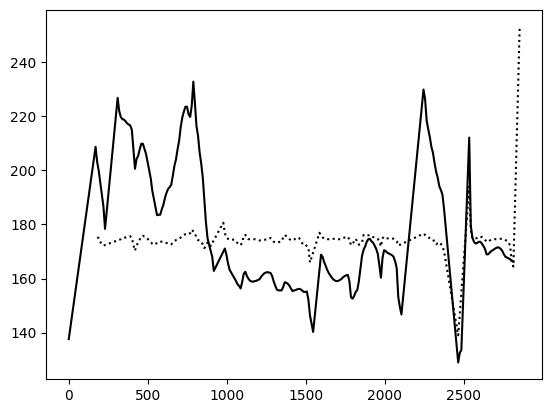

In [132]:
import librosa
def extract_pitch_interp(wave_in, sr, method='linear'): 
    
    times, pitch = extract_pitch(wave_in,sr, win=WIN_PITCH, bounds=BOUNDS)
    pitch[np.where(pitch == 0)] = np.nan
    
    # trim beginning and end nans
    notnans = np.flatnonzero(~np.isnan(pitch))
    if notnans.size:
        pitch = pitch[notnans[0]: notnans[-1]+1]
        times = times[notnans[0]: notnans[-1]+1]
    else: 
        pitch = times = []
       
    # interpolate nans
    start_value = end_value = np.mean(pitch[np.nonzero(~np.isnan(pitch))])
    pitch_interp = interpolate_pitch(pitch,
                                 method=method,
                                 start_value = start_value, 
                                 end_value = end_value)
    
    return times, pitch_interp

#wave_in, sr = librosa.load('..\\experiment\\revcor\\sounds\\chuang_fr_99_flat_ton1.wav')
wave_in, sr = librosa.load('sounds\\bottle_feel.wav')
times, pitch_interp = extract_pitch_interp(wave_in, sr, method='linear')
plt.plot(times,pitch_interp,'k')

wave_in, sr = librosa.load('sounds\\bottle_feel_175_flat.wav')
times, pitch_interp = extract_pitch_interp(wave_in, sr, method='linear')
plt.plot(times,pitch_interp,'k:')


## JJ's code

In [2]:
def load_transform_config(transform, config_file): 
    '''
        returns a dict with the randomization parameters of the transformation
    '''
    with open(config_file, "rb") as f:
        config_pars = tomli.load(f)
        config = config_pars[transform]
    return config 

#test
load_transform_config(transform='stretch',
                      config_file = "./configs/random_stretch_profile.toml")

{'window': {'len': 0.1, 'unit': 's'},
 'std': 1.5,
 'trunc': 1,
 'BPFtype': 'ramp'}

In [3]:
from cleese_stim.engines.phase_vocoder import bpf as cleese_bpf

def generate_custom_bpf_times(target_word_start, target_word_end, total_duration, transform_config):
    ''' 
    This generates a list of time_points outside the target word, 
    by concatenating the output of several calls to PhaseVocoder.create_BPF_time_vec(). 
    The output of this function is meant to be passed to PhaseVocoder.create_BPF 
    
    transform_config is the randomization parameters of the transformation, namely
    with open("./configs/random_stretch_profile.toml", "rb") as f:
        config_pars = tomli.load(f)
        config = config_pars[tr]
    
    '''
            
    # generate time_vec in the [0, word_start] period
    pre_duration = target_word_start
    bpf_time_pre, num_points, end_on_trans = cleese_bpf.createBPFtimeVec(pre_duration,
                                                                  transform_config)
    # generate time_vec in the [word_end, :] period
    post_duration = total_duration - target_word_end
    bpf_time_post, num_points, end_on_trans = cleese_bpf.createBPFtimeVec(post_duration,
                                                                   transform_config)
        
    # generate time_vec in the [word_start, word_end] period
    # NOTE: I QUESTION WHETHER APPROPRIATE
    word_duration = target_word_end - target_word_start
    bpf_time_word, num_points, end_on_trans = cleese_bpf.createBPFtimeVec(word_duration,
                                                                   transform_config)
    
    # create_BPF_time_vec works on a single duration parameter, 
    # and outputs from 0 to duration, so we then correct for the initial times of each period
    bpf_time_word = [bp + target_word_start for bp in bpf_time_word]
    bpf_time_post = [bp + target_word_end for bp in bpf_time_post]
    
    # drop duplicate time between bpfs
    del bpf_time_word[0]
    del bpf_time_post[0]
    
    bpf_time_total = list(bpf_time_pre) + bpf_time_word + bpf_time_post
    
    return bpf_time_total

# test
bpf_times = generate_custom_bpf_times(target_word_start = 2.1, 
                          target_word_end = 2.3, 
                          total_duration = 3, 
                          transform_config = load_transform_config('stretch',
                                                                   "./configs/random_stretch_profile.toml"))
print(bpf_times)
# NOTE FOR SOME REASON, createBPFtimeVec will add 'duration' twice at the end of bpf
    

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.1, 2.2, 2.3, 2.4, 2.5, 2.5999999999999996, 2.6999999999999997, 2.8, 2.9, 3.0, 3.0]


In [7]:
bpf_times = generate_custom_bpf_times(target_word_start = 2.1, 
                          target_word_end = 2.3, 
                          total_duration = 3, 
                          transform_config = load_transform_config(transform = 'stretch',
                                                                   config_file = "./configs/random_stretch_profile.toml"))



with open("./configs/random_pitch_profile.toml", "rb") as f:
    config_pars = tomli.load(f)
        
bpf = cleese_bpf.createBPF(tr = 'pitch',
               config = config_pars,
               BPFtime = bpf_times,
               numPoints = len(bpf_times),
               endOnTrans = False,
               eqFreqVec = None)
print(bpf)
  
    

[[   0.3          24.95771023]
 [   0.4        -125.58169119]]


## Sandbox

Try non consecutive breakpoints : <mark> works </mark>

In [118]:
bpf[:, 0].argsort()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

[[ 2.50000000e+00  1.00000000e+01  0.00000000e+00 -2.34412884e-01
   2.91485520e+02  1.51845929e+00  7.04347910e+02  2.23248314e+00
   1.28912945e+03 -4.38071783e+00  2.11741865e+03 -2.14030693e+00
   3.29061399e+03  3.06303694e+00  4.95233712e+03  2.88092345e+00
   7.30601488e+03 -4.13842984e+00  1.06397826e+04  2.77292317e+00
   1.53617575e+04  1.71601427e+00  2.20500000e+04 -1.53310570e+00]
 [ 2.70000000e+00  1.00000000e+01  0.00000000e+00  8.89613314e-01
   2.91485520e+02 -1.83232180e+00  7.04347910e+02  3.22929931e+00
   1.28912945e+03  2.00729514e+00  2.11741865e+03  2.64843381e+00
   3.29061399e+03  3.04642584e+00  4.95233712e+03 -1.53505840e-01
   7.30601488e+03  2.00510678e+00  1.06397826e+04  1.91214161e-02
   1.53617575e+04  1.28968740e+00  2.20500000e+04  7.12741902e-01]]


eq variation 1/1


[[ 0.00000000e+00  1.00000000e+01  0.00000000e+00  0.00000000e+00
   2.91485520e+02  0.00000000e+00  7.04347910e+02  0.00000000e+00
   1.28912945e+03  0.00000000e+00  2.11741865e+03  0.00000000e+00
   3.29061399e+03  0.00000000e+00  4.95233712e+03  0.00000000e+00
   7.30601488e+03  0.00000000e+00  1.06397826e+04  0.00000000e+00
   1.53617575e+04  0.00000000e+00  2.20500000e+04  0.00000000e+00]
 [ 2.40000000e+00  1.00000000e+01  0.00000000e+00  0.00000000e+00
   2.91485520e+02  0.00000000e+00  7.04347910e+02  0.00000000e+00
   1.28912945e+03  0.00000000e+00  2.11741865e+03  0.00000000e+00
   3.29061399e+03  0.00000000e+00  4.95233712e+03  0.00000000e+00
   7.30601488e+03  0.00000000e+00  1.06397826e+04  0.00000000e+00
   1.53617575e+04  0.00000000e+00  2.20500000e+04  0.00000000e+00]
 [ 2.50000000e+00  1.00000000e+01  0.00000000e+00 -2.34412884e-01
   2.91485520e+02  1.51845929e+00  7.04347910e+02  2.23248314e+00
   1.28912945e+03 -4.38071783e+00  2.11741865e+03 -2.14030693e+00
   3.290

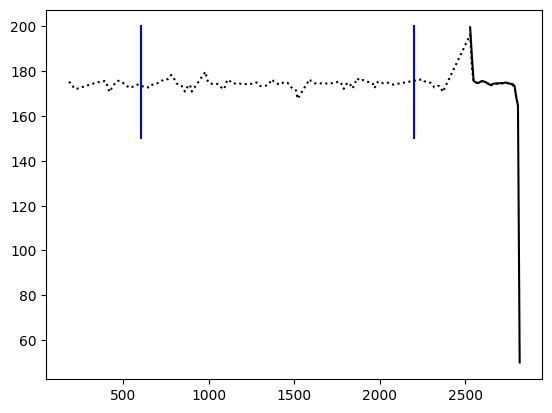

In [161]:
input_file = "sounds/bottle_feel_175_flat.wav"
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
Audio(data=wave_in, rate=sr)

#bpf_times = [0.,0.1,0.2,0.3,0.4,0.5,
#             2.3,2.4,2.5,2.6,2.7,2.8]

bpf_times = [2.5,2.7]

with open("./configs/random_timbre_profile.toml", "rb") as f:
    config_pars = tomli.load(f)
    
eqFreqVec = cleese_bpf.createBPFfreqs(config_pars)
        
bpf = cleese_bpf.createBPF(tr = 'eq',
               config = config_pars,
               BPFtime = bpf_times,
               numPoints = len(bpf_times),
               endOnTrans = False,
               eqFreqVec = eqFreqVec)

print(bpf)
# tapper down to zero at the end of the processed periods
bpf = np.append(bpf,
                [[ 0, 10,
                  0, 0,
                  2.91485520e+02, 0,
                  7.04347910e+02, 0,
                  1.28912945e+03, 0, 
                  2.11741865e+03, 0, 
                  3.29061399e+03, 0,
                  4.95233712e+03, 0,
                  7.30601488e+03, 0,
                  1.06397826e+04, 0, 
                  1.53617575e+04, 0, 
                  2.20500000e+04, 0],
                [ 2.4, 10,
                  0, 0,
                  2.91485520e+02, 0,
                  7.04347910e+02, 0,
                  1.28912945e+03, 0, 
                  2.11741865e+03, 0, 
                  3.29061399e+03, 0,
                  4.95233712e+03, 0,
                  7.30601488e+03, 0,
                  1.06397826e+04, 0, 
                  1.53617575e+04, 0, 
                  2.20500000e+04, 0], 
                [ 2.8, 10,
                  0, 0,
                  2.91485520e+02, 0,
                  7.04347910e+02, 0,
                  1.28912945e+03, 0, 
                  2.11741865e+03, 0, 
                  3.29061399e+03, 0,
                  4.95233712e+03, 0,
                  7.30601488e+03, 0,
                  1.06397826e+04, 0, 
                  1.53617575e+04, 0, 
                  2.20500000e+04, 0]], axis=0)

bpf = bpf[bpf[:, 0].argsort()]

wave_out,bpf_out = cleese.process_data(
        PhaseVocoder,
        wave_in,
        "./configs/random_timbre_profile.toml",
        sample_rate=sr,
        BPF=bpf)

Audio(data=wave_out, rate=sr)
print(bpf_out)

times, pitch_interp = extract_pitch_interp(wave_in, sr, method='linear')
plt.plot(times,pitch_interp,'k:')
times, pitch_interp = extract_pitch_interp(wave_out, sr, method='linear')
plt.plot(times,pitch_interp,'k')
plt.plot([600,600],[150,200],'b')
plt.plot([2200,2200],[150,200],'b')



In [138]:
PhaseVocoder.wavWrite(wave_out, 'output3.wav', sr)

## Paige's code

In [67]:
def generate_file(input_file, transforms, time_points, config_dict, output_file, audio_path, bpf_path):

  wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
  duration = len(wave_in) / float(sr)
  
  for key in config_dict:
    f = open(config_dict[key], "rb")
    if key == 'stretch':
      stretch_config = tomli.load(f)
    if key == 'pitch':
      pitch_config = tomli.load(f)
    if key == 'eq':
      eq_config = tomli.load(f)
  
  word = input_file.split("_")[-1]
  word = word.split(".")[0]
  
  time_points_word = np.array(time_points[word]) # values found in audacity
  # phrase before the word
  pre_duration = time_points_word[0]
  # phrase after the word
  post_duration = duration - time_points_word[1]
  word_duration = time_points_word[1] - time_points_word[0]
  
  def generateCustomBP(transform, pre_duration, post_duration, word_duration, config, config_file):
    bpf_time_pre, num_points, end_on_trans = PhaseVocoder.create_BPF_time_vec(
        pre_duration,
        config[transform]
    )
    bpf_time_post, num_points, end_on_trans = PhaseVocoder.create_BPF_time_vec(
        post_duration,
        config[transform]
    )
    bpf_time_word, num_points, end_on_trans = PhaseVocoder.create_BPF_time_vec(
        word_duration,
        config[transform]
    )
    # adjust to correct time points
    bpf_time_post = [bp + time_points_word[1] for bp in bpf_time_post]
    bpf_time_word = [bp + time_points_word[0] for bp in bpf_time_word]
    bpf_time_pre = list(bpf_time_pre)
    
    # drop duplicate time between bpfs
    del bpf_time_post[0]
    del bpf_time_pre[-1]
    
    full_time_points = bpf_time_pre + bpf_time_word + bpf_time_post
  
    num_points = len(full_time_points)
    
    eqFreqVec = None
    if transform == 'eq':
      eqFreqVec = PhaseVocoder.createBPFfreqs(config)
  
    # create a bpf for each of the transformations
    bpf_list = (PhaseVocoder.create_BPF(
        transform,
        config_file,
        full_time_points,
        num_points,
        end_on_trans,
        eqFreqVec
    ))
  
    return bpf_list
  
  bpf_dict = {}

  if 'stretch' in transforms:
    bpf_list = generateCustomBP('stretch', pre_duration, post_duration, word_duration, stretch_config, config_dict['stretch'])
    wave_out,bpf_out = cleese.process_data(
        PhaseVocoder,
        wave_in,
        config_dict['stretch'],
        sample_rate=sr,
        BPF=bpf_list
    )
    wave_in = wave_out
    bpf_dict['stretch'] = str(bpf_out)
  
  if 'pitch' in transforms:
    bpf_list = generateCustomBP('pitch', pre_duration, post_duration, word_duration, pitch_config, config_dict['pitch'])
    wave_out,bpf_out = cleese.process_data(
        PhaseVocoder,
        wave_in,
        config_dict['pitch'],
        sample_rate=sr,
        BPF=bpf_list
    )
    wave_in = wave_out
    bpf_dict['pitch'] = str(bpf_out)
  
  if 'eq' in transforms:
    bpf_list = generateCustomBP('eq', pre_duration, post_duration, word_duration, eq_config, config_dict['eq'])
    wave_out,bpf_out = cleese.process_data(
        PhaseVocoder,
        wave_in,
        config_dict['eq'],
        sample_rate=sr,
        BPF=bpf_list
    )
    wave_in = wave_out
    bpf_dict['eq'] = str(bpf_out)

  PhaseVocoder.wavWrite(wave_out, audio_path+output_file+'.wav', sr)
  with open(bpf_path + output_file+'.json', 'w') as f:
    json.dump(bpf_dict, f)


In [35]:
parent_dir = "C:\\Users\\ptut0\\Documents\\vocal_ambiguity\\stimulus_generation"

input_file = "./sounds/bottle_feel.wav"

config_dict = {
  'stretch': "./configs/random_stretch_profile.toml",
  'pitch': "./configs/random_pitch_profile.toml",
  'eq': "./configs/random_timbre_profile.toml"
}

transforms = ['stretch', 'pitch', 'eq']

num_files = 50

#The timepoints for each of the words of intrest for each phrase
time_points = {
  "feel" : [2.51, 2.71],
  "fill" : [2.32, 2.51],
  "beat" : [2.51, 2.69],
  "bit" : [2.41, 2.53],
  "fou" : [],
  "fut" : [0.23, 0.51],
  "brillant" : [2.49, 2.90],
  "bruyant" : [2.42, 2.90]
}

base_file = os.path.splitext(os.path.basename(input_file))[0]
file_path = os.path.join(parent_dir, base_file)
audio_path = os.path.join(parent_dir, base_file, 'audio\\') 
bpf_path = os.path.join(parent_dir, base_file, 'bpf\\')
if not os.path.exists(file_path):
  os.mkdir(file_path)
  os.mkdir(audio_path)
  os.mkdir(bpf_path)



for i in range(num_files):
  output_file  = base_file + f'_{i+1}'
  generate_file(input_file, transforms, time_points, config_dict, output_file, audio_path, bpf_path)

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         0.21238429]\n [0.1        0.42781447]\n [0.2        1.36223402]\n [0.3        0.8909512 ]\n [0.4        1.18738259]\n [0.5        0.29685975]\n [0.6        1.60814124]\n [0.7        0.78354962]\n [0.8        1.13353641]\n [0.9        1.        ]\n [1.         1.03352626]\n [1.1        0.21778415]\n [1.2        0.39644294]\n [1.3        0.71431735]\n [1.4        0.1540186 ]\n [1.5        1.80566125]\n [1.6        0.80694543]\n [1.7        0.9920155 ]\n [1.8        1.0280846 ]\n [1.9        1.96208122]\n [2.         0.8204204 ]\n [2.1        0.18849739]\n [2.2        1.38351309]\n [2.3        1.        ]\n [2.4        1.46052404]\n [2.5        1.        ]\n [2.51       0.71349925]\n [2.61       0.4055214 ]\n [2.71       1.82103505]\n [2.71       0.68813516]\n [2.81       2.31684206]\n [2.91       1.78502033]\n [2.95909297 0.27972625]]', 'pitch': '[[ 0.00000000e+00 -1.23027199e+02]\n [ 1.00000000e-01  9.46933685e+01]\n [ 2.00000000e-01 -5.75435234e+01]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.07443877]\n [0.1        2.36558799]\n [0.2        1.        ]\n [0.3        0.10110521]\n [0.4        2.31918142]\n [0.5        1.        ]\n [0.6        1.64930359]\n [0.7        0.68388132]\n [0.8        1.56519623]\n [0.9        2.45239905]\n [1.         1.74723791]\n [1.1        0.90064208]\n [1.2        1.68542572]\n [1.3        0.18896808]\n [1.4        1.12060514]\n [1.5        0.68899814]\n [1.6        1.52939519]\n [1.7        1.04880906]\n [1.8        2.28095545]\n [1.9        1.37466728]\n [2.         2.36008554]\n [2.1        1.        ]\n [2.2        1.61641215]\n [2.3        0.70889322]\n [2.4        2.46306819]\n [2.5        0.69425505]\n [2.51       0.164326  ]\n [2.61       1.89299551]\n [2.71       1.66976724]\n [2.71       1.79999772]\n [2.81       0.84772937]\n [2.91       2.15590431]\n [2.95909297 1.        ]]', 'pitch': '[[ 0.00000000e+00 -2.36328759e+00]\n [ 1.00000000e-01  9.87419599e+01]\n [ 2.00000000e-01  1.43283401e+02]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.95663884]\n [0.1        0.05219576]\n [0.2        0.84832123]\n [0.3        0.72347667]\n [0.4        0.64444501]\n [0.5        1.50931232]\n [0.6        1.        ]\n [0.7        2.15982812]\n [0.8        2.23639825]\n [0.9        2.07226607]\n [1.         1.00911744]\n [1.1        1.45517312]\n [1.2        1.52506098]\n [1.3        1.        ]\n [1.4        1.        ]\n [1.5        1.00853215]\n [1.6        1.30963745]\n [1.7        0.21001835]\n [1.8        1.64056414]\n [1.9        0.50157623]\n [2.         2.31571271]\n [2.1        0.28319751]\n [2.2        1.        ]\n [2.3        1.11660647]\n [2.4        1.71899268]\n [2.5        1.18999925]\n [2.51       1.50750722]\n [2.61       2.48598933]\n [2.71       1.63844056]\n [2.71       0.4304326 ]\n [2.81       1.99275304]\n [2.91       0.21826001]\n [2.95909297 1.03511872]]', 'pitch': '[[ 0.00000000e+00 -1.33694798e+02]\n [ 1.00000000e-01 -2.41117240e+01]\n [ 2.00000000e-01  1.05962010e+00]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.19895828]\n [0.1        1.74673616]\n [0.2        1.20908005]\n [0.3        1.23338508]\n [0.4        1.08134821]\n [0.5        1.11976992]\n [0.6        2.34844116]\n [0.7        1.9522935 ]\n [0.8        1.        ]\n [0.9        1.0818611 ]\n [1.         0.87545013]\n [1.1        1.35431899]\n [1.2        1.90678224]\n [1.3        1.        ]\n [1.4        0.02755743]\n [1.5        2.17201974]\n [1.6        0.59495642]\n [1.7        1.18394019]\n [1.8        0.46058326]\n [1.9        1.58953088]\n [2.         1.46205358]\n [2.1        1.81822999]\n [2.2        2.27017782]\n [2.3        0.01909564]\n [2.4        1.16348863]\n [2.5        0.67458529]\n [2.51       0.10664304]\n [2.61       0.87576488]\n [2.71       1.43698149]\n [2.71       1.4027617 ]\n [2.81       0.52599347]\n [2.91       0.19295979]\n [2.95909297 1.53042312]]', 'pitch': '[[ 0.00000000e+00 -8.77987612e+01]\n [ 1.00000000e-01  1.39728165e+01]\n [ 2.00000000e-01  1.04996850e+02]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.38783225]\n [0.1        1.73442909]\n [0.2        0.16182307]\n [0.3        0.50658705]\n [0.4        0.57457135]\n [0.5        1.77363772]\n [0.6        0.90886317]\n [0.7        0.19040293]\n [0.8        1.        ]\n [0.9        0.11357268]\n [1.         2.41650239]\n [1.1        1.77719328]\n [1.2        0.66878923]\n [1.3        1.49349965]\n [1.4        2.41044657]\n [1.5        0.16364042]\n [1.6        1.        ]\n [1.7        1.        ]\n [1.8        1.43762937]\n [1.9        0.79337259]\n [2.         0.37318414]\n [2.1        0.4000302 ]\n [2.2        0.20796499]\n [2.3        0.30192134]\n [2.4        1.        ]\n [2.5        1.89104302]\n [2.51       1.44899736]\n [2.61       1.00952038]\n [2.71       0.41110337]\n [2.71       2.34124051]\n [2.81       1.11194236]\n [2.91       2.3684455 ]\n [2.95909297 1.06533497]]', 'pitch': '[[ 0.00000000e+00 -3.45837468e+01]\n [ 1.00000000e-01 -1.81992835e+01]\n [ 2.00000000e-01  1.14292679e+02]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.602903  ]\n [0.1        1.35867264]\n [0.2        1.        ]\n [0.3        0.03861647]\n [0.4        1.        ]\n [0.5        2.31689263]\n [0.6        1.32092949]\n [0.7        0.73936624]\n [0.8        0.73202982]\n [0.9        2.11400351]\n [1.         0.93078907]\n [1.1        1.49154424]\n [1.2        2.41216755]\n [1.3        0.05528725]\n [1.4        1.71149537]\n [1.5        1.61993875]\n [1.6        1.26255823]\n [1.7        2.22560446]\n [1.8        1.19055128]\n [1.9        1.        ]\n [2.         0.90815514]\n [2.1        1.75887109]\n [2.2        0.72590058]\n [2.3        2.41598076]\n [2.4        1.94237579]\n [2.5        0.00318357]\n [2.51       2.42347012]\n [2.61       1.23292023]\n [2.71       0.91499416]\n [2.71       1.53143707]\n [2.81       1.73678103]\n [2.91       0.72029767]\n [2.95909297 1.        ]]', 'pitch': '[[ 0.00000000e+00  1.38692619e+02]\n [ 1.00000000e-01  2.46993914e+01]\n [ 2.00000000e-01  2.43238324e+01]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         0.7414161 ]\n [0.1        1.47181834]\n [0.2        0.74738549]\n [0.3        0.28931532]\n [0.4        2.07824221]\n [0.5        0.8471253 ]\n [0.6        1.83523079]\n [0.7        2.41494547]\n [0.8        1.        ]\n [0.9        0.2632214 ]\n [1.         1.52051643]\n [1.1        0.80522208]\n [1.2        0.96601761]\n [1.3        1.        ]\n [1.4        1.70743558]\n [1.5        1.81695907]\n [1.6        1.        ]\n [1.7        1.73520455]\n [1.8        0.60258554]\n [1.9        1.3201923 ]\n [2.         1.        ]\n [2.1        1.85934178]\n [2.2        0.48288794]\n [2.3        1.72118427]\n [2.4        1.        ]\n [2.5        1.04367107]\n [2.51       2.39280973]\n [2.61       1.30510868]\n [2.71       1.32047143]\n [2.71       2.03466202]\n [2.81       0.55317491]\n [2.91       1.53636133]\n [2.95909297 1.68227392]]', 'pitch': '[[ 0.00000000e+00  5.71569445e+01]\n [ 1.00000000e-01  1.44060374e+02]\n [ 2.00000000e-01  4.10653797e+01]\n [ 3.0000

pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.        ]\n [0.1        1.68981998]\n [0.2        2.18544291]\n [0.3        1.9471525 ]\n [0.4        1.        ]\n [0.5        0.02159862]\n [0.6        0.9476935 ]\n [0.7        2.26437079]\n [0.8        2.25361827]\n [0.9        0.92276537]\n [1.         1.92454829]\n [1.1        1.21414435]\n [1.2        0.30159683]\n [1.3        0.08590574]\n [1.4        1.21561659]\n [1.5        0.42157508]\n [1.6        0.82058584]\n [1.7        1.84685311]\n [1.8        0.9393938 ]\n [1.9        1.93783084]\n [2.         0.80804595]\n [2.1        1.9993329 ]\n [2.2        0.28987059]\n [2.3        1.6327308 ]\n [2.4        2.14702107]\n [2.5        1.10092921]\n [2.51       1.80005604]\n [2.61       0.96805412]\n [2.71       0.47467005]\n [2.71       1.        ]\n [2.81       0.20407853]\n [2.91       0.97413851]\n [2.95909297 0.64718337]]', 'pitch': '[[ 0.00000000e+00  2.40075591e+01]\n [ 1.00000000e-01  9.13411872e+01]\n [ 2.00000000e-01  1.26181705e+02]\n [ 3.0000

pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         0.32771413]\n [0.1        1.70142288]\n [0.2        2.40760323]\n [0.3        1.51864312]\n [0.4        1.75026331]\n [0.5        1.53064849]\n [0.6        2.29934193]\n [0.7        1.        ]\n [0.8        1.17323995]\n [0.9        0.47586148]\n [1.         0.0446568 ]\n [1.1        0.77544592]\n [1.2        0.75794744]\n [1.3        0.89713342]\n [1.4        1.        ]\n [1.5        0.40300319]\n [1.6        1.        ]\n [1.7        1.41751039]\n [1.8        0.75868221]\n [1.9        2.46049853]\n [2.         1.33754111]\n [2.1        1.74090054]\n [2.2        1.50876885]\n [2.3        2.18023762]\n [2.4        0.26266138]\n [2.5        1.17597052]\n [2.51       1.36029542]\n [2.61       0.02231529]\n [2.71       1.        ]\n [2.71       1.22660804]\n [2.81       1.59138608]\n [2.91       0.13343747]\n [2.95909297 2.2969456 ]]', 'pitch': '[[ 0.00000000e+00 -1.07681796e+02]\n [ 1.00000000e-01  5.77863433e+01]\n [ 2.00000000e-01 -6.45531519e+01]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         0.12238488]\n [0.1        0.41548509]\n [0.2        1.21994931]\n [0.3        0.43558126]\n [0.4        1.46174307]\n [0.5        0.94835338]\n [0.6        2.26059898]\n [0.7        1.79389545]\n [0.8        1.        ]\n [0.9        2.19372352]\n [1.         2.47281477]\n [1.1        2.06347903]\n [1.2        0.45046131]\n [1.3        0.91942208]\n [1.4        1.97895217]\n [1.5        0.50690332]\n [1.6        0.83030619]\n [1.7        2.00941277]\n [1.8        0.98135621]\n [1.9        2.23489794]\n [2.         1.08181047]\n [2.1        1.44450172]\n [2.2        2.42270008]\n [2.3        1.6869327 ]\n [2.4        0.98814777]\n [2.5        1.08324468]\n [2.51       0.76976938]\n [2.61       1.08390496]\n [2.71       2.12167189]\n [2.71       2.3691103 ]\n [2.81       2.36216144]\n [2.91       1.        ]\n [2.95909297 2.30631182]]', 'pitch': '[[ 0.00000000e+00  1.16519426e+02]\n [ 1.00000000e-01 -1.47537418e+02]\n [ 2.00000000e-01  7.31181249e+01]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         0.26927108]\n [0.1        1.        ]\n [0.2        1.10606415]\n [0.3        1.95299348]\n [0.4        0.50266044]\n [0.5        0.23079944]\n [0.6        1.        ]\n [0.7        0.30196862]\n [0.8        2.47823233]\n [0.9        1.        ]\n [1.         0.66907492]\n [1.1        1.74547395]\n [1.2        2.19382013]\n [1.3        0.74477792]\n [1.4        1.        ]\n [1.5        2.45826345]\n [1.6        0.7890978 ]\n [1.7        0.47215418]\n [1.8        2.11563518]\n [1.9        0.76009821]\n [2.         1.        ]\n [2.1        0.57711265]\n [2.2        1.64782093]\n [2.3        2.06629434]\n [2.4        1.        ]\n [2.5        0.577078  ]\n [2.51       1.96507565]\n [2.61       2.27529767]\n [2.71       1.78547049]\n [2.71       0.49319562]\n [2.81       2.24328292]\n [2.91       1.12769391]\n [2.95909297 1.07050614]]', 'pitch': '[[ 0.00000000e+00 -3.70561750e+01]\n [ 1.00000000e-01  2.79574780e+01]\n [ 2.00000000e-01  6.08698730e+01]\n [ 3.0000

pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         2.33193799]\n [0.1        2.39921861]\n [0.2        0.73364251]\n [0.3        1.        ]\n [0.4        0.8410969 ]\n [0.5        0.78495142]\n [0.6        0.25707191]\n [0.7        2.04410643]\n [0.8        2.09422649]\n [0.9        1.        ]\n [1.         2.42720756]\n [1.1        1.6727862 ]\n [1.2        0.24447522]\n [1.3        1.8856566 ]\n [1.4        1.12360625]\n [1.5        2.01037486]\n [1.6        0.30474935]\n [1.7        0.71257784]\n [1.8        1.38575667]\n [1.9        0.47034817]\n [2.         1.47028558]\n [2.1        0.85457384]\n [2.2        1.76911905]\n [2.3        2.08797005]\n [2.4        1.13484425]\n [2.5        0.57003124]\n [2.51       0.33757497]\n [2.61       1.78704482]\n [2.71       0.21517436]\n [2.71       2.06613446]\n [2.81       0.36518221]\n [2.91       1.        ]\n [2.95909297 1.32461277]]', 'pitch': '[[ 0.00000000e+00 -1.37681827e+02]\n [ 1.00000000e-01 -1.11618568e+02]\n [ 2.00000000e-01  4.16648182e+01]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         1.45593566]\n [0.1        1.73635261]\n [0.2        1.93926697]\n [0.3        0.42174549]\n [0.4        0.74543102]\n [0.5        0.52756953]\n [0.6        1.94609074]\n [0.7        0.80419126]\n [0.8        1.        ]\n [0.9        1.50031109]\n [1.         0.82938122]\n [1.1        1.87852419]\n [1.2        1.        ]\n [1.3        1.35942044]\n [1.4        0.43233649]\n [1.5        0.82759365]\n [1.6        0.40088586]\n [1.7        1.        ]\n [1.8        0.73010109]\n [1.9        1.71090532]\n [2.         1.16842072]\n [2.1        0.22582036]\n [2.2        1.29569529]\n [2.3        1.13653256]\n [2.4        0.49856356]\n [2.5        2.43466584]\n [2.51       1.93461128]\n [2.61       1.        ]\n [2.71       1.26059328]\n [2.71       0.72369643]\n [2.81       2.14147577]\n [2.91       0.41025388]\n [2.95909297 1.        ]]', 'pitch': '[[ 0.00000000e+00  1.38623509e+02]\n [ 1.00000000e-01  8.68363418e+01]\n [ 2.00000000e-01  6.32688231e+01]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1
WARN: stereo file detected. Reading only left channel.
stretch variation 1/1


{'stretch': '[[0.         1.33350433]\n [0.1        1.        ]\n [0.2        1.        ]\n [0.3        1.15331135]\n [0.4        0.4989688 ]\n [0.5        0.81709964]\n [0.6        1.84207018]\n [0.7        1.42609539]\n [0.8        0.99908916]\n [0.9        0.5149147 ]\n [1.         0.68310185]\n [1.1        1.        ]\n [1.2        0.96519401]\n [1.3        1.        ]\n [1.4        1.06339693]\n [1.5        0.06178681]\n [1.6        0.21822007]\n [1.7        1.        ]\n [1.8        2.44780587]\n [1.9        0.42906741]\n [2.         1.50645747]\n [2.1        0.34652502]\n [2.2        1.87932378]\n [2.3        2.3175748 ]\n [2.4        1.29389209]\n [2.5        1.83678423]\n [2.51       1.18342936]\n [2.61       1.24073382]\n [2.71       1.74097338]\n [2.71       1.14237369]\n [2.81       0.98111642]\n [2.91       0.4033049 ]\n [2.95909297 0.02045369]]', 'pitch': '[[ 0.00000000e+00  2.41389893e+01]\n [ 1.00000000e-01 -6.21082275e+01]\n [ 2.00000000e-01 -1.44838834e+02]\n [ 3.0000

pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         2.12259954]\n [0.1        1.48130448]\n [0.2        0.66841901]\n [0.3        0.21112812]\n [0.4        1.3871123 ]\n [0.5        0.44441749]\n [0.6        0.99739022]\n [0.7        0.83256163]\n [0.8        0.26107356]\n [0.9        1.        ]\n [1.         1.86795016]\n [1.1        0.93582759]\n [1.2        0.08707498]\n [1.3        0.92927672]\n [1.4        1.        ]\n [1.5        1.62103801]\n [1.6        0.65883091]\n [1.7        1.        ]\n [1.8        0.85708299]\n [1.9        1.1927462 ]\n [2.         0.63967249]\n [2.1        0.0810689 ]\n [2.2        1.        ]\n [2.3        1.        ]\n [2.4        1.        ]\n [2.5        1.2160498 ]\n [2.51       0.4497383 ]\n [2.61       1.53327411]\n [2.71       1.        ]\n [2.71       0.68972434]\n [2.81       1.34680838]\n [2.91       1.        ]\n [2.95909297 2.37617079]]', 'pitch': '[[ 0.00000000e+00 -4.25784280e+01]\n [ 1.00000000e-01  1.09325955e+02]\n [ 2.00000000e-01 -4.13937128e+01]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.00000000e+00 1.21793157e+00]\n [1.00000000e-01 2.08664497e+00]\n [2.00000000e-01 1.04388441e+00]\n [3.00000000e-01 1.00000000e+00]\n [4.00000000e-01 9.55851398e-01]\n [5.00000000e-01 8.25883992e-01]\n [6.00000000e-01 1.00000000e+00]\n [7.00000000e-01 2.49986527e+00]\n [8.00000000e-01 9.83294271e-02]\n [9.00000000e-01 1.54222460e+00]\n [1.00000000e+00 1.00000000e+00]\n [1.10000000e+00 6.40199330e-01]\n [1.20000000e+00 7.88943407e-01]\n [1.30000000e+00 1.59399474e+00]\n [1.40000000e+00 1.00000000e+00]\n [1.50000000e+00 4.52275469e-01]\n [1.60000000e+00 1.88737992e-03]\n [1.70000000e+00 7.13161874e-01]\n [1.80000000e+00 6.50307636e-01]\n [1.90000000e+00 2.33281094e+00]\n [2.00000000e+00 1.26222461e+00]\n [2.10000000e+00 1.99241930e+00]\n [2.20000000e+00 7.92635216e-01]\n [2.30000000e+00 1.71031472e-01]\n [2.40000000e+00 3.55187508e-01]\n [2.50000000e+00 2.39682394e+00]\n [2.51000000e+00 1.05764041e+00]\n [2.61000000e+00 1.38869296e+00]\n [2.71000000e+00 2.52507737e-01]\n 

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         1.13993749]\n [0.1        1.93616987]\n [0.2        0.03240805]\n [0.3        0.00865107]\n [0.4        0.59586596]\n [0.5        1.        ]\n [0.6        2.01790496]\n [0.7        1.60835508]\n [0.8        1.32364362]\n [0.9        1.8048555 ]\n [1.         1.        ]\n [1.1        2.10358427]\n [1.2        0.19475947]\n [1.3        0.59591554]\n [1.4        0.93983692]\n [1.5        1.59896859]\n [1.6        0.37584703]\n [1.7        0.84248003]\n [1.8        1.04592718]\n [1.9        1.56766737]\n [2.         0.46113607]\n [2.1        0.17504251]\n [2.2        0.98191708]\n [2.3        1.50325271]\n [2.4        1.        ]\n [2.5        0.08072663]\n [2.51       1.        ]\n [2.61       0.93888258]\n [2.71       0.26992119]\n [2.71       1.14288596]\n [2.81       2.01566864]\n [2.91       1.42142563]\n [2.95909297 0.89437949]]', 'pitch': '[[ 0.00000000e+00  4.35547765e+01]\n [ 1.00000000e-01 -1.06137146e+02]\n [ 2.00000000e-01  1.26105049e+02]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
pitch variation 1/1
eq variation 1/1


{'stretch': '[[0.         1.00084022]\n [0.1        0.56855978]\n [0.2        0.17507357]\n [0.3        0.3547358 ]\n [0.4        0.20051873]\n [0.5        0.80529349]\n [0.6        0.96853813]\n [0.7        1.        ]\n [0.8        0.32514168]\n [0.9        0.68029601]\n [1.         2.2132618 ]\n [1.1        1.05029795]\n [1.2        2.12485354]\n [1.3        0.64208916]\n [1.4        0.82143717]\n [1.5        2.17151663]\n [1.6        0.75183411]\n [1.7        2.15615754]\n [1.8        1.86117181]\n [1.9        2.05752046]\n [2.         0.31071489]\n [2.1        1.433263  ]\n [2.2        1.23186494]\n [2.3        1.95283685]\n [2.4        1.        ]\n [2.5        1.        ]\n [2.51       0.49564402]\n [2.61       0.8221671 ]\n [2.71       1.01922292]\n [2.71       1.99597852]\n [2.81       0.34604364]\n [2.91       1.53085482]\n [2.95909297 1.        ]]', 'pitch': '[[ 0.00000000e+00  2.98410387e+01]\n [ 1.00000000e-01 -8.20500808e+01]\n [ 2.00000000e-01  1.11099781e+02]\n [ 3.0000

WARN: stereo file detected. Reading only left channel.
stretch variation 1/1
